In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [7]:
input_params = {
    'x_path' : '/ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_MTfilt_rna.csv',
    'y_path' : '/ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_Ylabels.csv',
    'fdr' : 0.1,
    'thresh_fdr': 0.1,
    'spec' : 0.2,
    'y_factor': True,
    'niter' : 500,
    'SLIDE_top_feats': 20,
    # 'pure_homo' : False,
    'pure_homo' : True,
    'delta' : [0.01],
    'lambda' : [0.1],
    # 'out_path': '/ix3/djishnu/alw399/SLIDE_py/example_results/love_homo'
    'out_path': '/ix3/djishnu/alw399/SLIDE_py/example_results/slide_py'
    
}

In [8]:
import sys
sys.path.append('src/SLIDE')

In [9]:
from slide import OptimizeSLIDE
slider = OptimizeSLIDE(input_params)

In [ ]:
%%time
slider.run_pipeline(verbose=True, n_workers=1)


### PARAMETERS ###

x_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_MTfilt_rna.csv
y_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_Ylabels.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 20
pure_homo: True
delta: [0.01]
lambda: [0.1]
out_path: /ix3/djishnu/alw399/SLIDE_py/example_results/slide_py
n_workers: 1

###### DATA ######

227 samples
1061 features
84.6% cases
15.4% controls

##################

Running LOVE with delta=0.01 and lambda=0.1
LOVE found 131 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 131
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [14:37<00:00, 877.03s/it]


Found 2 standalone LF
Finding interacting LF...


Processing subsets:  50%|█████     | 1/2 [12:45<12:45, 765.63s/it]

In [ ]:
# slider.create_summary_table(slider.input_params['out_path'])


### Debugging

In [6]:
out_iter = '/ix3/djishnu/alw399/SLIDE_py/example_results/slide_py/0.1_0.5_out/love_result.pkl'

slider.show_params()
slider.load_love(out_iter)


### PARAMETERS ###

x_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_MTfilt_rna.csv
y_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_Ylabels.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 10
rep_CV: 50
pure_homo: True
delta: [0.1]
lambda: [0.5]
out_path: /ix3/djishnu/alw399/SLIDE_py/example_results/slide_py
n_workers: 1

###### DATA ######

227 samples
1061 features
84.6% cases
15.4% controls

##################



In [40]:
n_workers = 1
verbose=True

slider.run_SLIDE(
    latent_factors=slider.latent_factors, 
    niter=slider.input_params['niter'], 
    spec=slider.input_params['spec'], 
    fdr=slider.input_params['fdr'],
    verbose=verbose,
    n_workers=n_workers,
    outpath=out_iter
)

Calculated f_size: 133
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

No standalone LF found


In [ ]:
from knockoffs import Knockoffs

machop = Knockoffs(slider.data['Y'].values, slider.latent_factors.values)
machop 

In [90]:
result = machop.filter_knockoffs_iterative(machop.z2, machop.y, fdr=0.1, niter=10)
result

array([ 9, 12, 36, 74], dtype=int32)

In [7]:
delta = 0.1
lbd = 0.5

out_iter = input_params['out_path'] + f'/{delta}_{lbd}_out'

In [8]:
slider.load_love(out_iter + '/love_result.pkl')

In [67]:
slider.sig_LFs = np.loadtxt(out_iter + '/sig_LFs.txt', dtype=str).reshape(-1).tolist()
slider.sig_interacts = np.loadtxt(out_iter + '/sig_interacts.txt', dtype=str).reshape(-1).tolist()

In [68]:
from knockoffs import Knockoffs

n = slider.latent_factors.shape[0]

slider.interaction_terms = Knockoffs.get_interaction_terms(
    slider.latent_factors[slider.sig_LFs].values, 
    slider.latent_factors[slider.sig_interacts].values
).reshape(n, -1)

slider.interaction_terms.shape

(227, 1)

100%|██████████| 10/10 [00:00<00:00, 71.12it/s]


defaultdict(list,
            {'s3': array([0.78780488, 0.86184211, 0.76426426, 0.625     , 0.725     ,
                    0.68780488, 0.61184211, 0.625     , 0.76426426, 0.68780488]),
             'full_random': array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
                    0.48780488, 0.5       , 0.5       , 0.5       , 0.5       ]),
             'partial_random': array([0.78780488, 0.9       , 0.78780488, 0.7       , 0.8       ,
                    0.78780488, 0.78780488, 0.8       , 0.78780488, 0.9       ])})

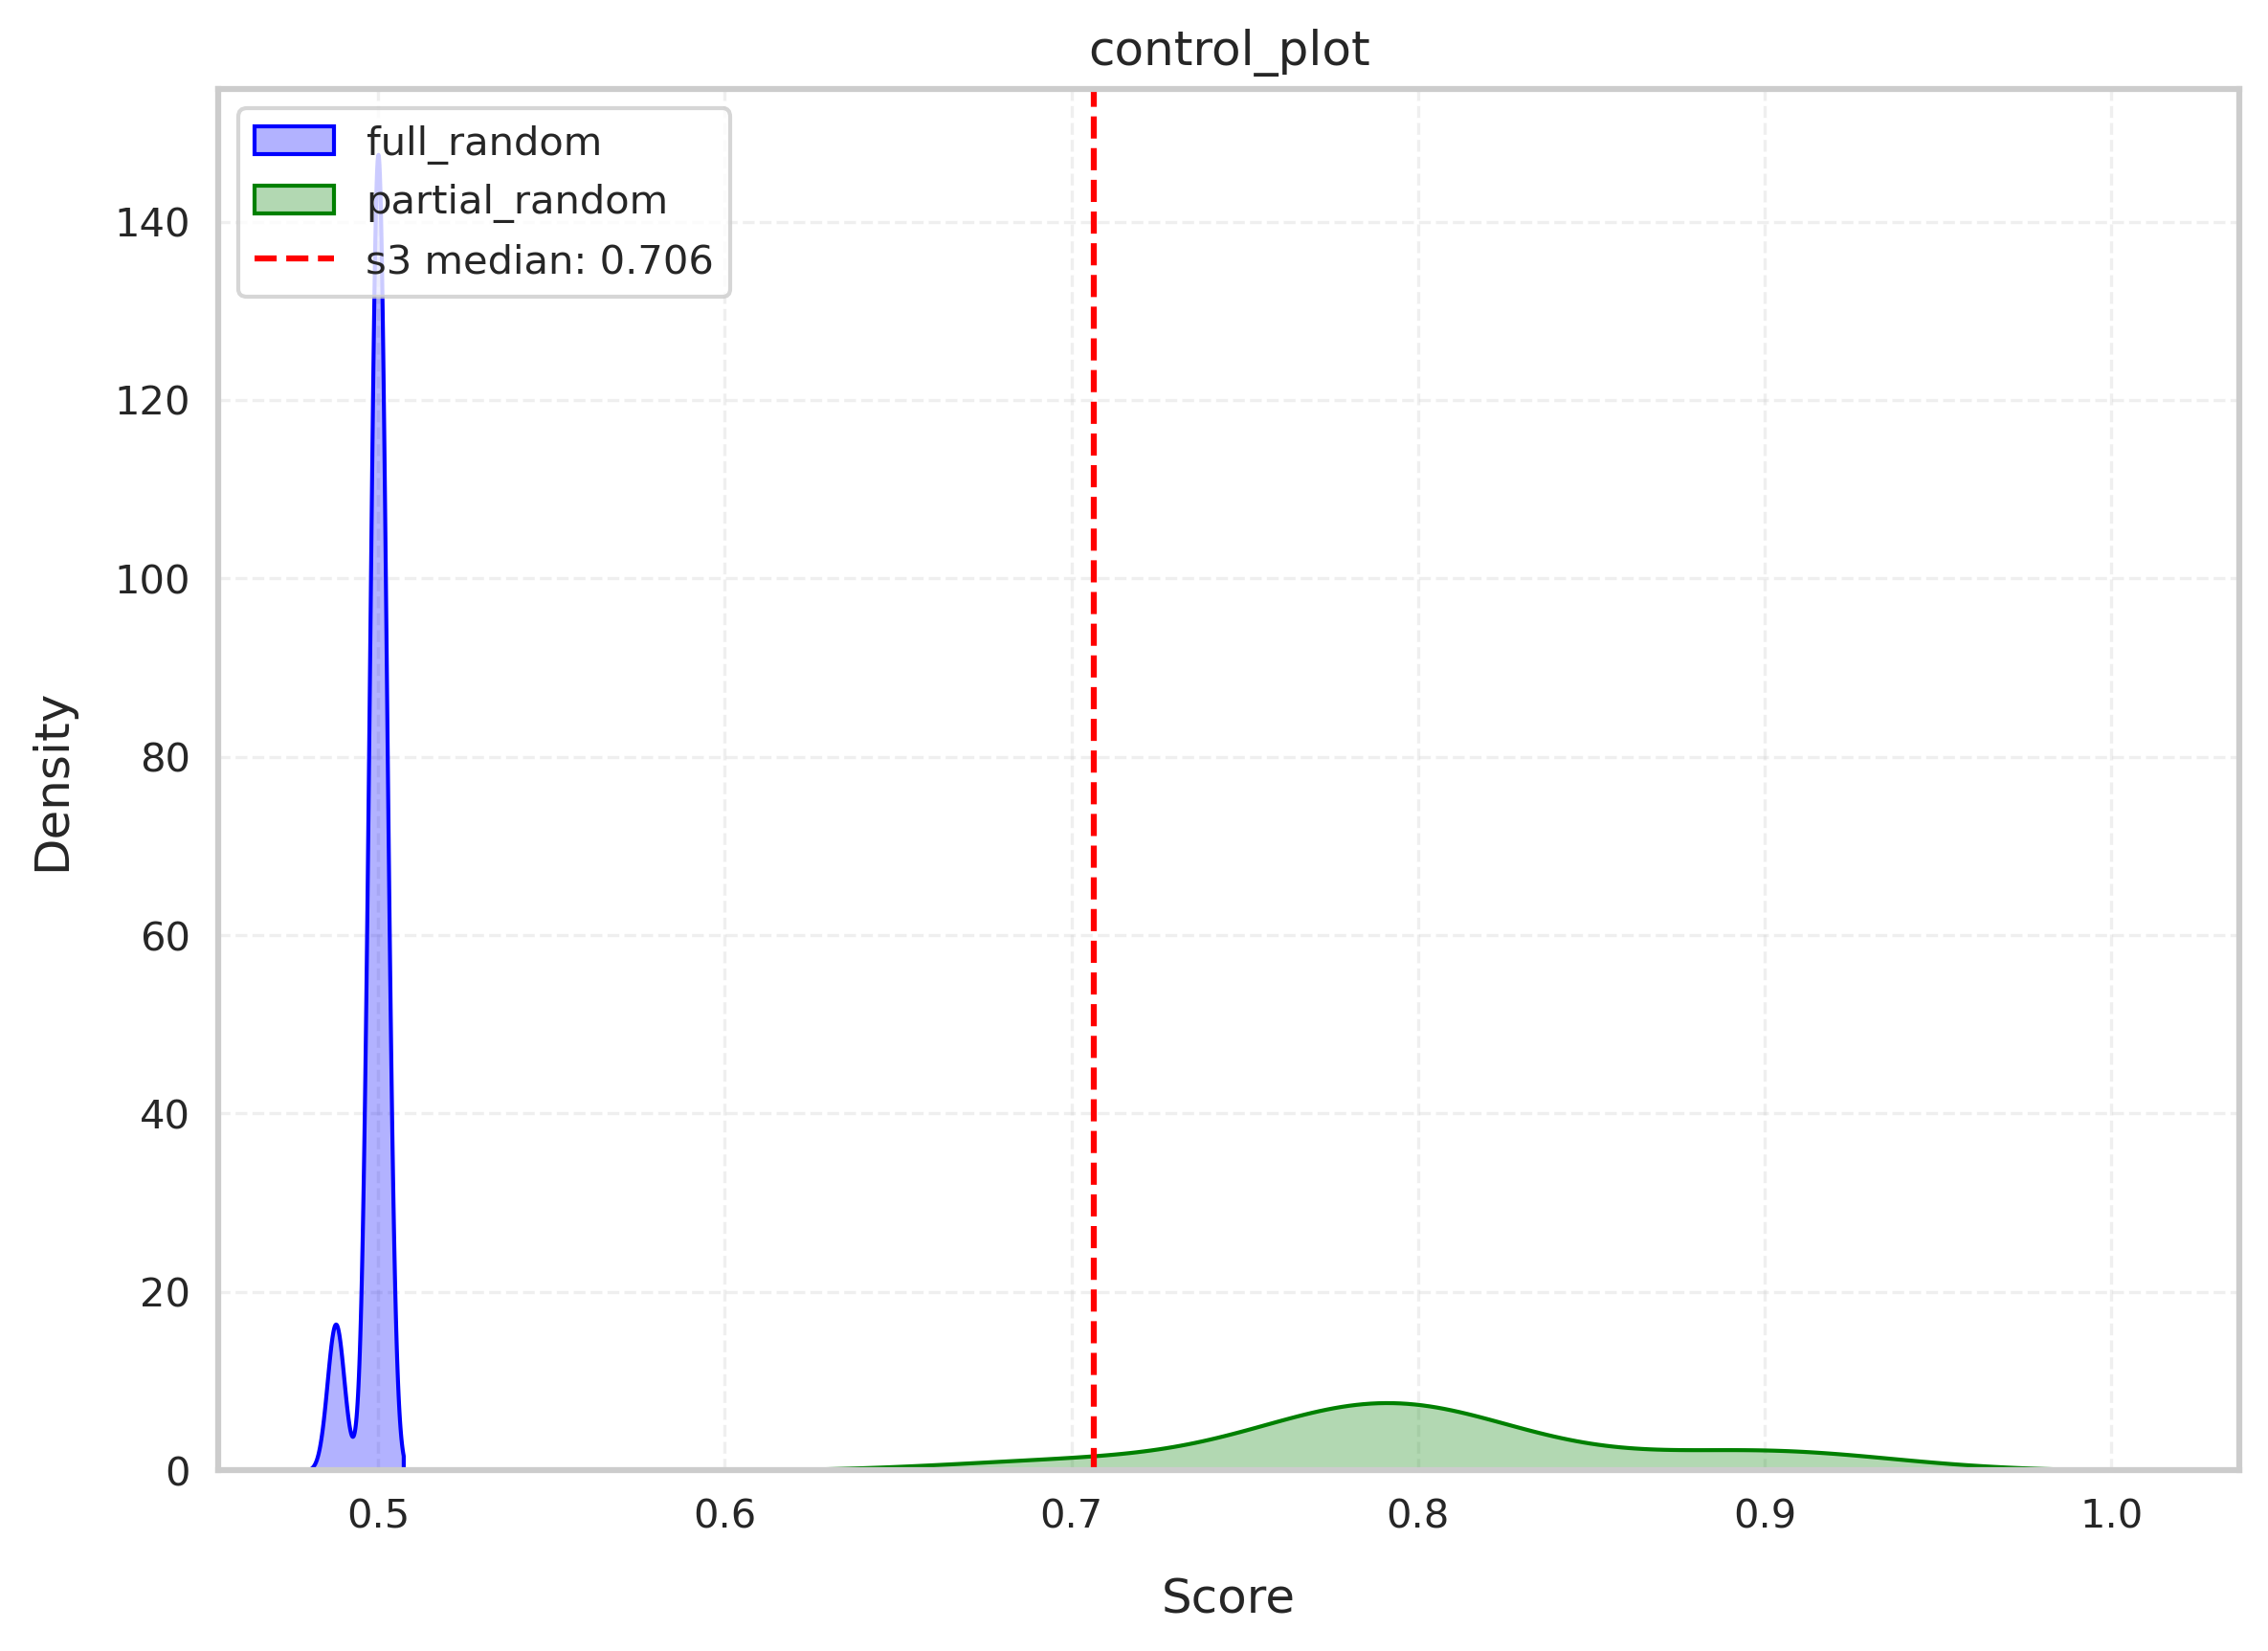

In [70]:
slider.score_performance(
    s1=slider.latent_factors[slider.sig_LFs], 
    s2=slider.interaction_terms, 
    n_iters=10, 
    test_size=0.2,
    scaler='standard', 
    outdir=out_iter
)

In [84]:
slider.A[slider.sig_LFs].sort_values(by='Z12', key=abs, ascending=False)

,Z12
Trbv15,1.000000
Trav16n,1.000000
Trbv1,-1.000000
Lypd1,-0.245062
Trbc2,-0.198257
...,...
Mest,0.000000
Lmo4,0.000000
Bcl2a1b,0.000000
Irf5,0.000000


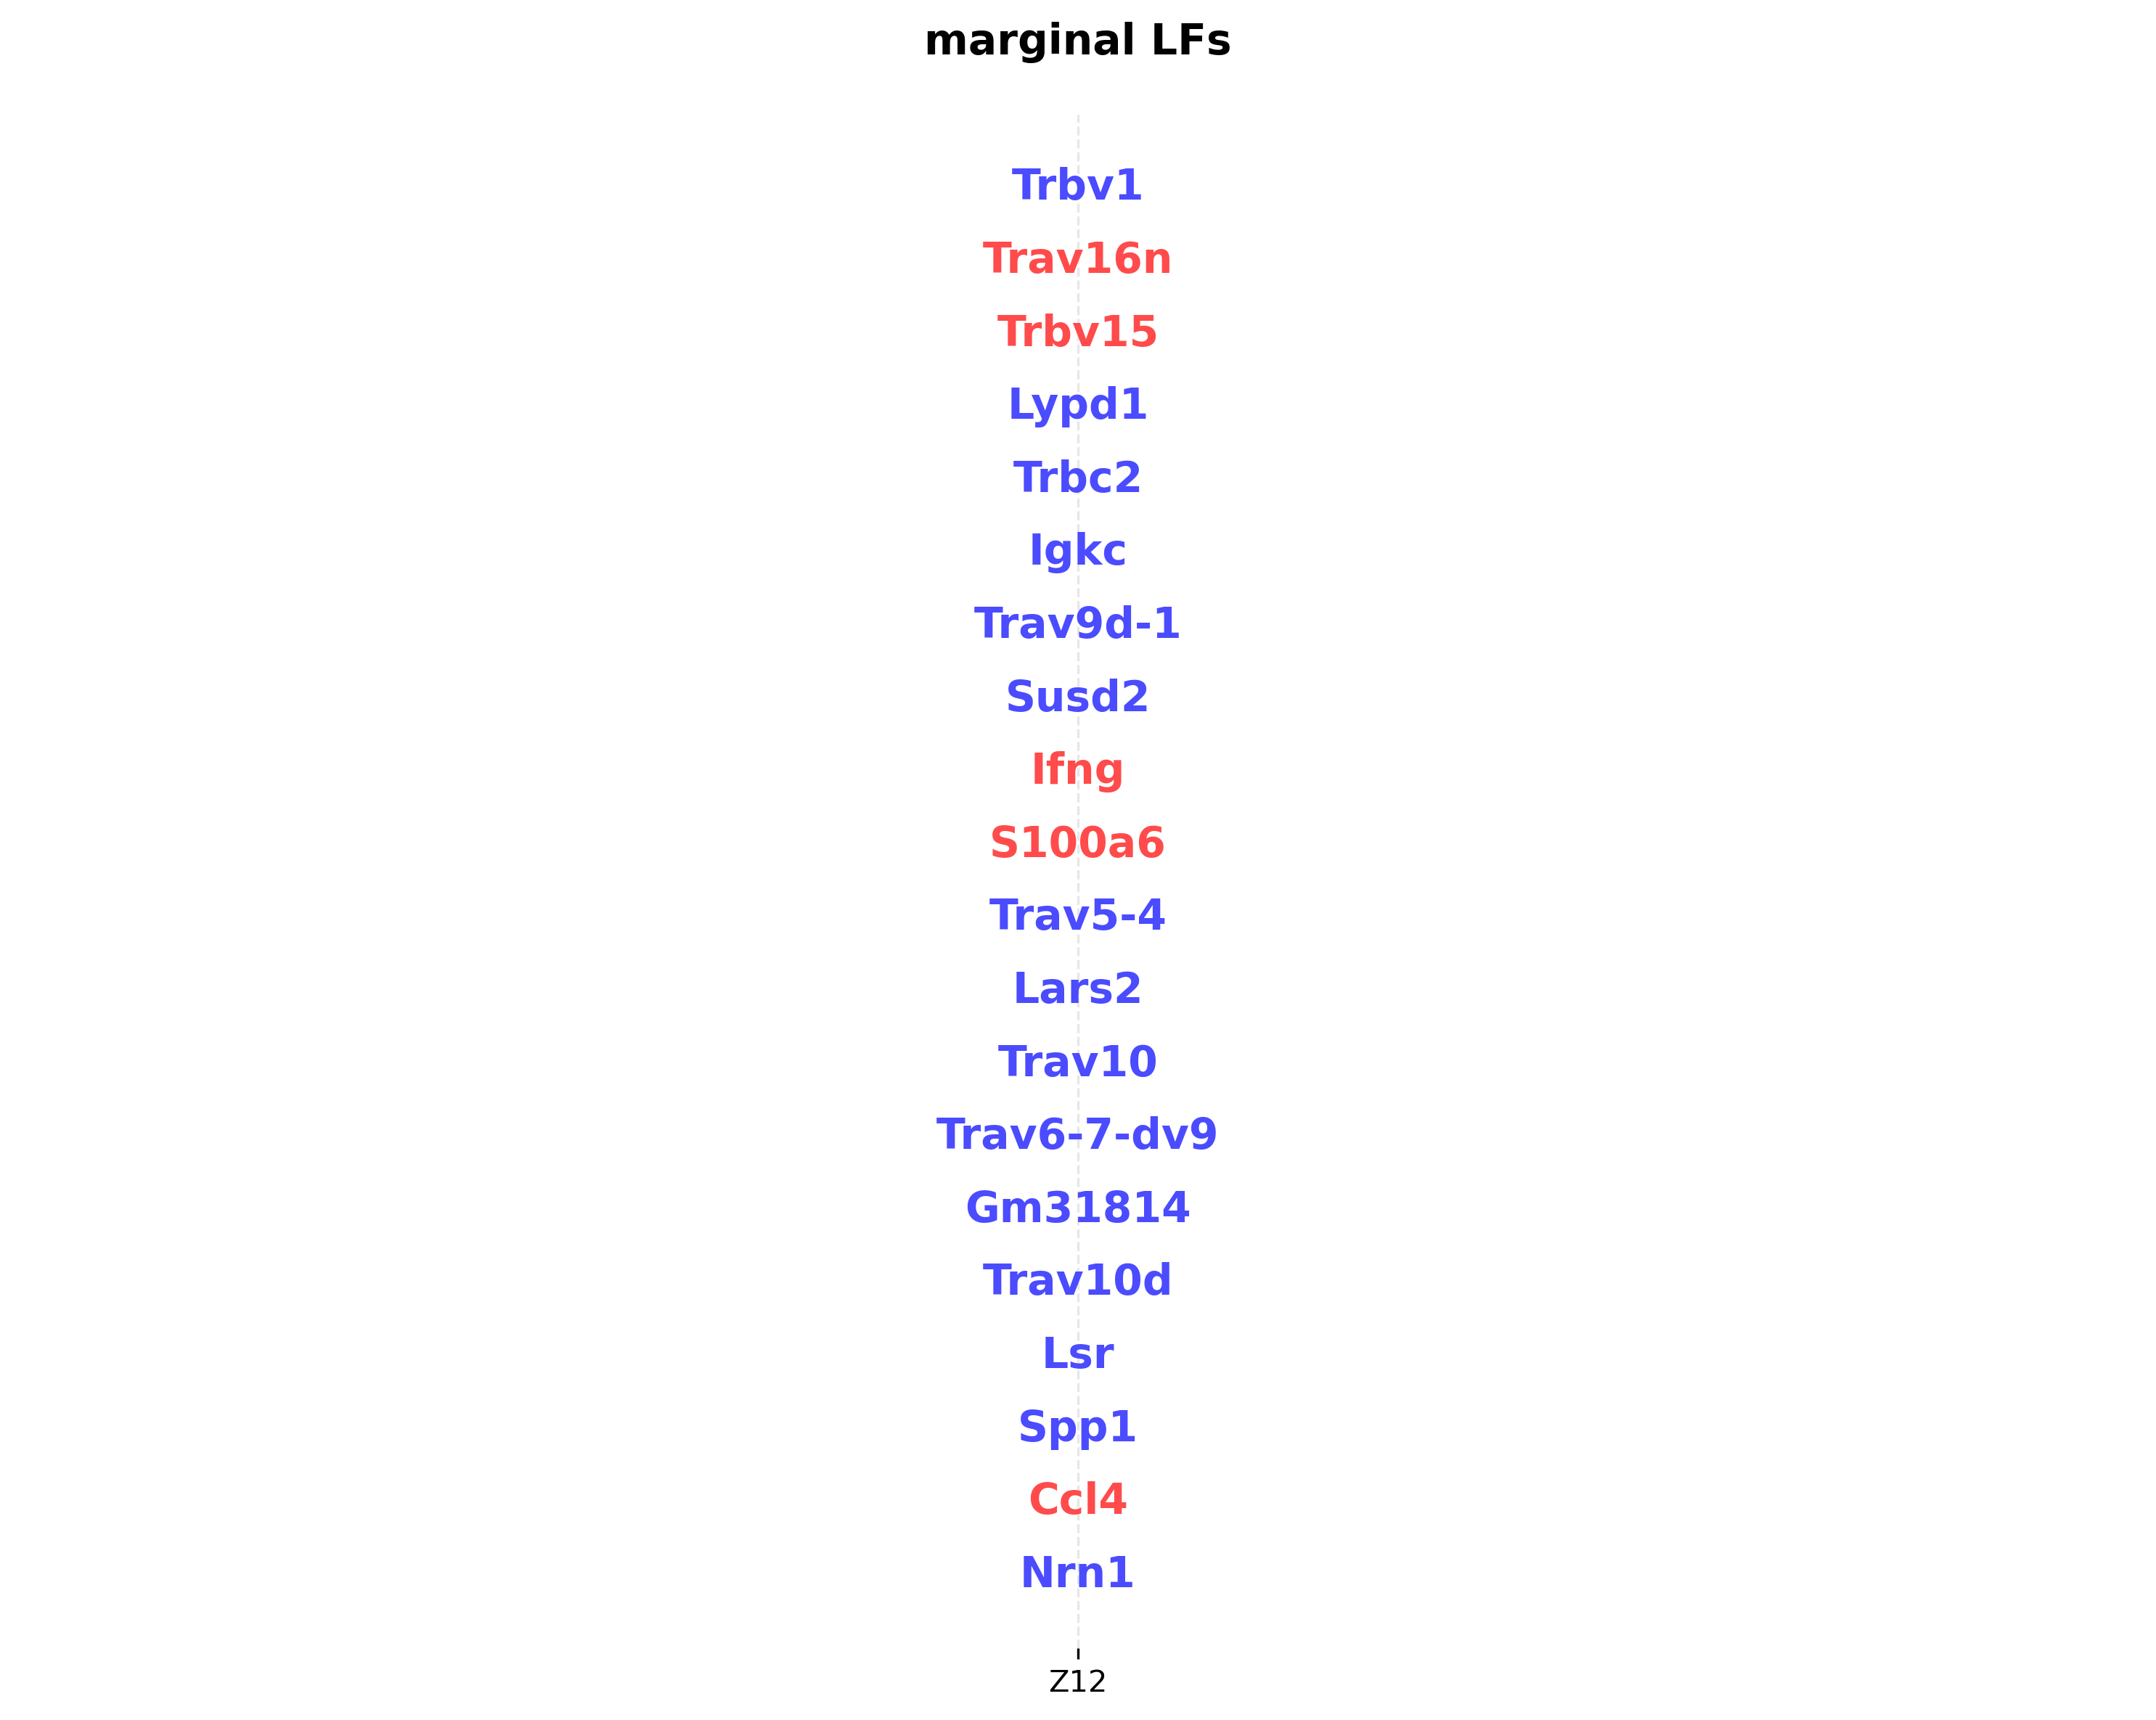

In [85]:
from plotting import Plotter

sig_LF_genes = {str(lf): slider.get_LF_genes(
    lf=lf, 
    top_feats=20,
    outpath=out_iter) for lf in slider.sig_LFs}
_ = Plotter.plot_latent_factors(sig_LF_genes, loadings=slider.A, outdir=out_iter, title='marginal_LFs')

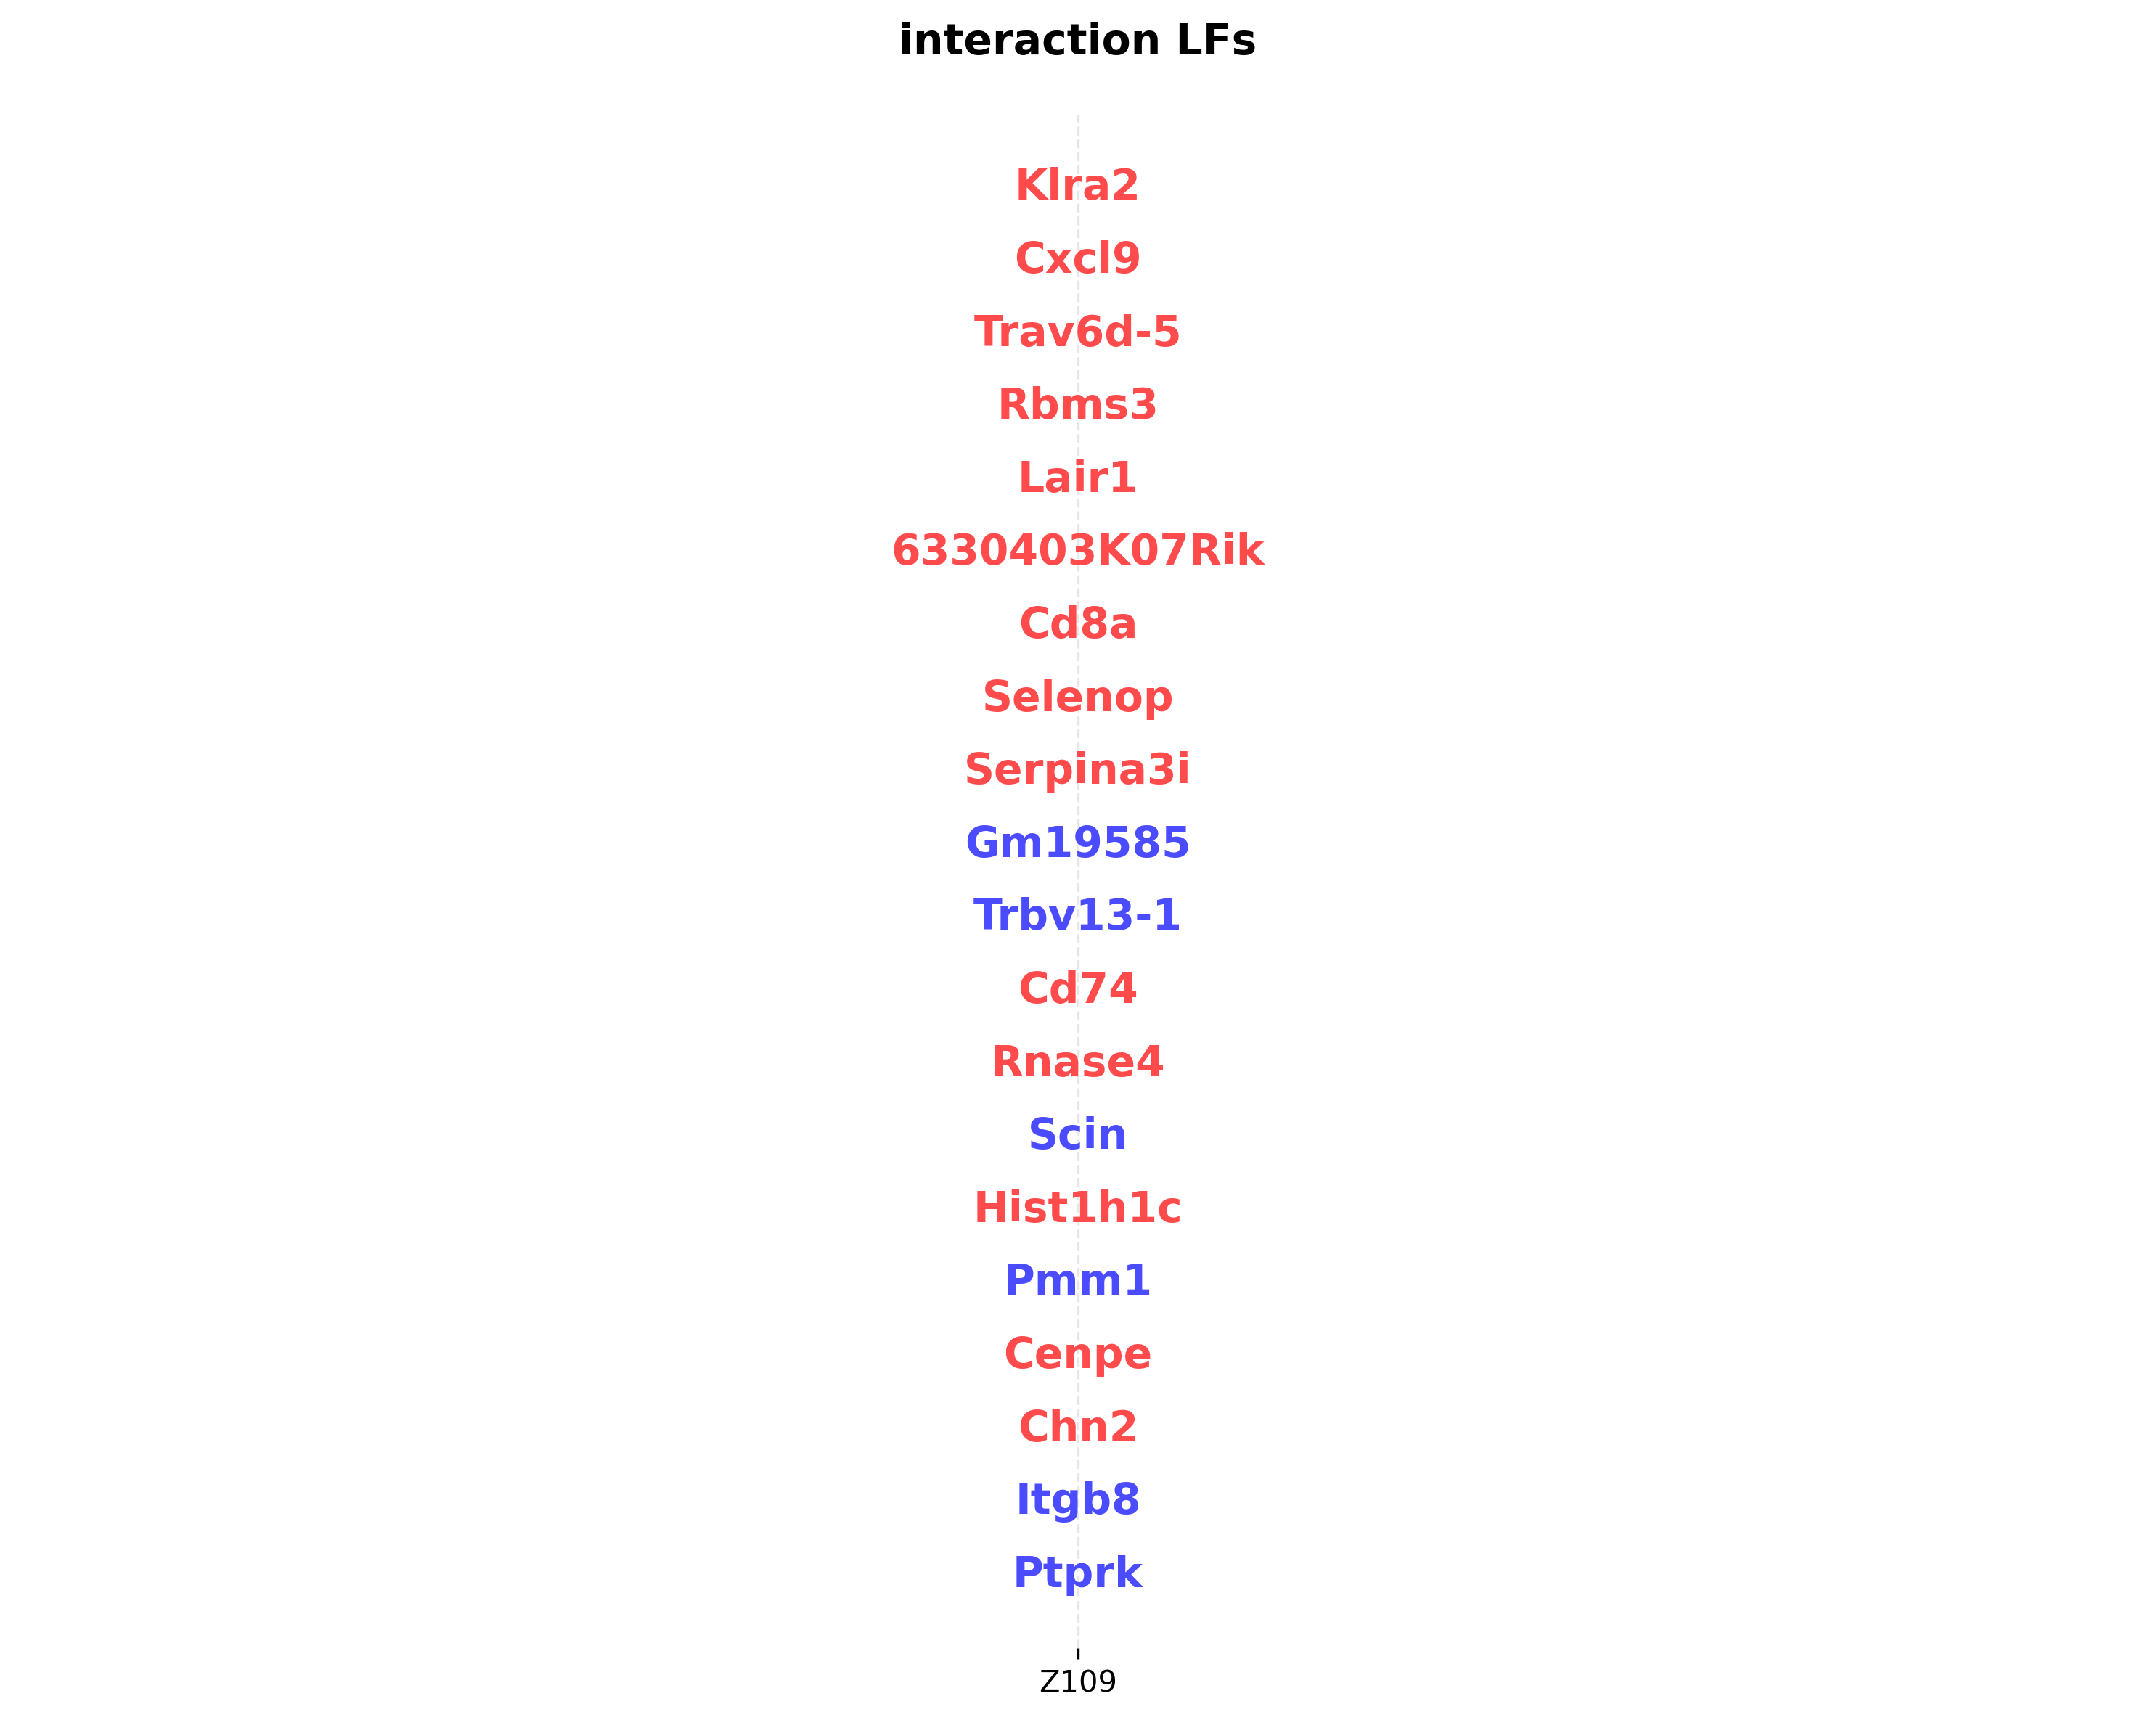

In [86]:
sig_interact_genes = {str(lf): slider.get_LF_genes(
    lf=lf, 
    top_feats=20,
    outpath=out_iter) for lf in slider.sig_interacts}
_ = Plotter.plot_latent_factors(sig_interact_genes, loadings=slider.A, outdir=out_iter, title='interaction_LFs')